In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.utils import shuffle
import statsmodels.api as sm
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#dataset = datasets.load_boston()
dataset = pd.read_csv('Boston.csv', index_col=0)

In [3]:
dataset.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

In [4]:

dataset.shape


(506, 14)

In [5]:
df = dataset
df2 = dataset


In [6]:
lm = sm.OLS.from_formula('medv ~ lstat', df)
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           5.08e-88
Time:                        12:49:16   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
result.rsquared, result.fvalue, result.params.Intercept, result.params.lstat

(0.5441462975864799, 601.6178711098955, 34.55384087938308, -0.9500493537579922)

In [8]:
new = pd.DataFrame([[1, 5], [1, 10], [1, 15]], columns=['Intercept', 'lstat'])

In [9]:
result.predict(new)

0    29.803594
1    25.053347
2    20.303101
dtype: float64

In [10]:
def predict(res, new):
    
    # Get the predicted values
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    
    # Get the confidence interval for the model (and rename the columns to something a bit more useful)
    ci = res.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # Now a little bit of matrix multiplication to get the confidence intervals for the predictions
    ci = ci.T.dot(new.T).T
    
    # And finally wrap up the confidence intervals with the predicted values
    return pd.concat([fit, ci], axis=1)

In [11]:
predict(result, new)

,fit,lower,upper
0,29.803594,28.317716,31.289472
1,25.053347,23.186975,26.919720
2,20.303101,18.056234,22.549967


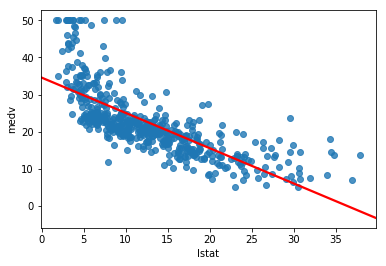

In [12]:
import seaborn as sns
sns.regplot('lstat', 'medv', df, line_kws = {"color":"r"}, ci=None)

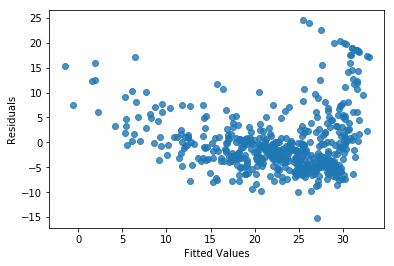

In [13]:
fitted_values = pd.Series(result.fittedvalues, name="Fitted Values")
residuals = pd.Series(result.resid, name="Residuals")
sns.regplot(fitted_values, residuals, fit_reg=False)

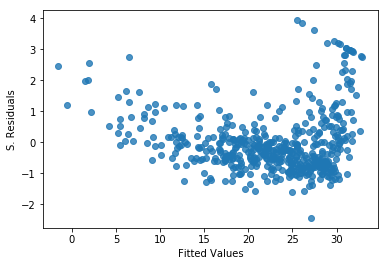

In [14]:
s_residuals = pd.Series(result.resid_pearson, name="S. Residuals")
sns.regplot(fitted_values, s_residuals,  fit_reg=False)

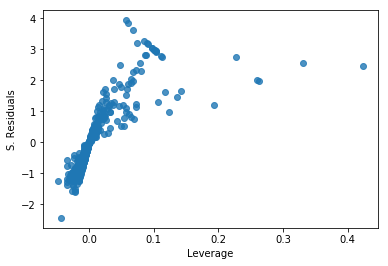

In [15]:
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = pd.Series(OLSInfluence(result).influence, name = "Leverage")
sns.regplot(leverage, s_residuals,  fit_reg=False)

In [16]:
#Lets' do the same thing with more classical aproach - X_pred - y_pred

X, y = shuffle(dataset.iloc[:,0:12], dataset['medv'], random_state=7)
#X.describe()

In [17]:
num_training = int(0.8 * len(X))
X_train, y_train = X[:num_training], y[:num_training]
X_test, y_test = X[num_training:], y[num_training:]

In [18]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
y_pred_lin = linear.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lin)
evs = explained_variance_score(y_test, y_pred_lin) 
print("\n#### Linear model performance ####")
print("Mean squared error =", round(mse, 2))
print("Explained variance score =", round(evs, 2))


#### Linear model performance ####
Mean squared error = 18.2
Explained variance score = 0.78


Mean Squared Error looks quite big, and variance score is quite far from 1.

# Multiple Linear Regression

In [20]:
model = sm.OLS.from_formula('medv ~ lstat + age', df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           2.98e-88
Time:                        12:49:18   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

In [21]:
# All columns (except medv, which is our response)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv'])), df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          6.72e-135
Time:                        12:49:18   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

in the above regression output, ${\tt age}$ and ${\tt indus}$ have a high p-value. So we may wish to run a regression excluding these predictors:

In [22]:
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv', 'age', 'indus'])), df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          5.54e-137
Time:                        12:49:18   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.0

# Interactions

In [23]:
print(sm.OLS.from_formula('medv ~ lstat*age', df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           4.86e-88
Time:                        12:49:18   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

In [24]:
lm.fit2 = sm.OLS.from_formula('medv ~ lstat + np.square(lstat)', df).fit()
print(lm.fit2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          1.56e-112
Time:                        12:49:18   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           42.8620      0.872  

In [25]:
lm.fit = sm.OLS.from_formula('medv ~ lstat', df).fit()
print(sm.stats.anova_lm(lm.fit, lm.fit2))

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0     504.0  19472.381418      0.0         NaN         NaN           NaN
1     503.0  15347.243158      1.0  4125.13826  135.199822  7.630116e-28


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


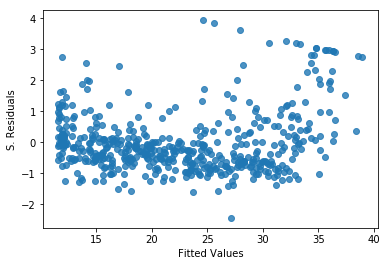

In [26]:
fitted_values = pd.Series(lm.fit2.fittedvalues, name="Fitted Values")
residuals = pd.Series(lm.fit2.resid, name="S. Residuals")
sns.regplot(fitted_values, s_residuals,  fit_reg=False)

# Let's plot the relative importance of the features

In [27]:
X, y = shuffle(df2.iloc[:,:12], df2['medv'], random_state=7)
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)

X.shape


(506, 12)

In [28]:
def plot_feature_importances(feature_importances, title, feature_names):
    # Normalize the importance values 
    feature_importances = 100.0 * (feature_importances / max(feature_importances))

    # Sort the index values and flip them so that they are arranged in decreasing order of importance
    index_sorted = np.flipud(np.argsort(feature_importances))

    # Center the location of the labels on the X-axis (for display purposes only)
    pos = np.arange(index_sorted.shape[0]) + 0.5

    # Plot the bar graph
    plt.figure()
    plt.bar(pos, feature_importances[index_sorted], align='center')
    plt.xticks(pos, feature_names[index_sorted])
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()

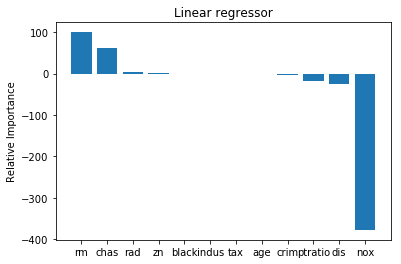

In [29]:
plot_feature_importances(linear.coef_, 'Linear regressor', dataset.columns)


# Qualitative Predictors

In [30]:
df2 = pd.read_csv("Carseats.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [31]:
sm.OLS.from_formula('Sales ~ Income:Advertising+Price:Age + ' + "+".join(df2.columns.difference(['Sales'])), df2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          6.14e-166
Time:                        12:49:19   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5756      1.009      6.519      0.000       4.592       8.559
ShelveLoc[T.Good]       4.8487      0.153     31.724      0.000       4.548       5.149
ShelveLoc[T.Medium]     1.9533      0.126     15.531      0.000       1.706       2.201
US[T.Yes]              -0.1576      0.149     -1.058      0.291      -0.450       0.135
Urban[T.Yes]            0.1402      0.112      1.247      0.213      -0.081       0.361
Income:Advertising      0.0008      0.000      2.698      0.007       0.000       0.001
Price:Age               0.0001      0.000      0.801      0.424      -0.000       0.000
Advertising             0.0702      0.023      3.107      0.002       0.026       0.115
Age                    -0.0579      0.016     -3.633      0.000      -0.089      -0.027
CompPrice               0.0929      0.004     22.567      0.000       0.085       0.101
Education              -0.0209      0.020     -1.063      0.288      -0.059       0.018
Income                  0.0109      0.003      4.183      0.000       0.006       0.016
Population              0.0002      0.000      0.433      0.665      -0.001       0.001
Price                  -0.1008      0.007    -13.549      0.000      -0.115      -0.086
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.147
Skew:                           0.129   Prob(JB):                        0.564
Kurtosis:                       3.050   Cond. No.                     1.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Applied

In [32]:
df3 = pd.read_csv("Auto.csv")
df3.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [33]:
sm.OLS.from_formula('mpg ~ horsepower', df3).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     598.0
Date:                Tue, 03 Apr 2018   Prob (F-statistic):           4.39e-81
Time:                        12:49:19   Log-Likelihood:                -1196.6
No. Observations:                 397   AIC:                             2397.
Df Residuals:                     395   BIC:                             2405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.0221      0.719     55.655      0.000      38.608      41.436
horsepower    -0.1584      0.006    -24.454      0.000      -0.171      -0.146
==============================================================================
Omnibus:                       16.902   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.851
Skew:                           0.502   Prob(JB):                     0.000133
Kurtosis:                       3.267   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
reg = linear_model.LinearRegression()
X1=pd.to_numeric(df3['horsepower']).values.reshape(1, -1)
y1=pd.to_numeric(df3['mpg']).values.reshape(1, -1)
reg.fit(X1,y1)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)